# 로지스틱 회귀분석_실습

# Step0. 패키지 불러오기

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import metrics
from sklearn.preprocessing import scale

# Step1. 분석에 필요한 데이터 구성하기

In [10]:
ds = pd.read_csv("통신고객이탈.csv", engine = 'python')
ds['CHURN'].replace(to_replace='Active', value = 0, inplace = True)
ds['CHURN'].replace(to_replace='Churned', value = 1, inplace = True)
ds.head()

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,0,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,0,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,0,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,0,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,0,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0


# Step2. 데이터 전처리

## 결측치 처리

In [11]:
ds.isnull().sum(axis=0)

CHURN                 0
CUSTOMER_ID           0
GENDER                0
AGE                   0
CHARGE_TYPE           0
HANDSET               0
USAGE_BAND            0
SERVICE_DURATION      0
DROPPED_CALLS         0
PEAK_CALLS_NO         0
PEAK_CALLS_TIME       0
WEEKEND_CALLS_NO      0
WEEKEND_CALLS_TIME    0
TOTAL_CALLS_NO        0
TOTAL_CALLS_TIME      0
dtype: int64

## 데이터 분할

In [12]:
np.random.seed(seed= 1234)
msk = np.random.rand(ds.shape[0],) < 0.7
ds_train = ds[msk]
ds_test = ds[~msk]
print("train data size:{}".format(ds_train.shape))
print("test data size:{}".format(ds_test.shape))

train data size:(635, 15)
test data size:(295, 15)


### train데이터 : 635건, test 데이터 : 295건

## train데이터에 상수 추가

In [13]:
ds_train = sm.add_constant(ds_train)
ds_train.head()

,const,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,1.0,0,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,1.0,0,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,1.0,0,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
5,1.0,0,K105530,M,51,CAT 100,S80,Med,49.43,3,289,486.6,1,31.8,427,903.3
6,1.0,0,K106210,F,30,CAT 100,ASAD170,Med,32.30,6,427,729.6,12,52.8,490,907.2


# Step3. 로지스틱 회귀모델 및 회귀계수 검토

In [14]:
log_model = sm.Logit.from_formula("""CHURN ~ C(GENDER) + AGE + C(CHARGE_TYPE) + C(HANDSET) +
                    C(USAGE_BAND) + SERVICE_DURATION + DROPPED_CALLS + PEAK_CALLS_NO + PEAK_CALLS_TIME + WEEKEND_CALLS_NO + 
                    WEEKEND_CALLS_TIME +
                    TOTAL_CALLS_NO + 
                    TOTAL_CALLS_TIME + 1"""
                     , ds_train)
log_result = log_model.fit(method='bfgs')
print(log_result.summary())

         Current function value: 0.261293
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 42
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  635
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                           29
Date:                Sun, 10 Feb 2019   Pseudo R-squ.:                  0.4660
Time:                        18:05:48   Log-Likelihood:                -165.92
converged:                      False   LL-Null:                       -310.70
                                        LLR p-value:                 9.369e-45
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.1342      2

/Users/jeong-utae/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/jeong-utae/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/jeong-utae/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### 설명력 : 0.46

# Step4. 예측 및 성능 평가

In [15]:
y_pred = log_result.predict(ds_test)
y_pred_class = (y_pred > 0.5).astype(int)
y_pred_class.head()

3    0
4    0
7    0
8    0
9    0
dtype: int64

In [16]:
print("Accuracy : {0:.3f}".format(metrics.accuracy_score(ds_test["CHURN"], y_pred_class)))

Accuracy : 0.898


### 로지스틱 회귀모델로 목표변수를 0.898예측했다.

# Step5. 결론 도출

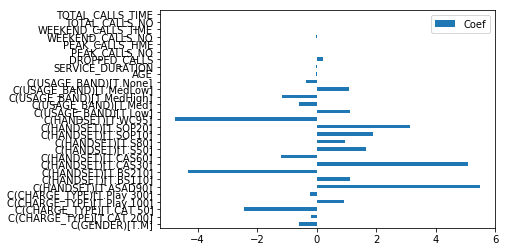

In [17]:
ds_logistic_coef = pd.DataFrame({"Coef":log_result.params.values[1:]}, index = log_model.exog_names[1:])
ds_logistic_coef.plot.barh(y = "Coef")

### HANDSET이 ASAD 90일수록 CHURN이다.